# RGB image compression

Compressing color images with PNG in the RGB domain.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import pylab
import math
import numpy as np
from scipy import signal
import cv2
import os
#!pwd
!ln -sf ~/MRVC/src/deadzone.py .
!ln -sf ~/MRVC/src/frame.py .
!ln -sf ~/MRVC/src/distortion.py .
!ln -sf ~/MRVC/src/information.py
!ln -sf ~/MRVC/src/debug.py
!ln -sf ~/MRVC/src/image_3.py
import deadzone as Q
import distortion
import image_3 as frame
#import rate

## Configuration area

In [2]:
# Prefix of the RGB image to be quantized.

home = os.environ["HOME"]
fn = home + "/MRVC/sequences/stockholm/"

# Number of quantization steps.
Q_steps = 8

## Generation of the optimal RD curve

The optimal RD curve can be generated with:

1. The RD curve of each RGB channel is computed, for a number of quantization steps.
2. The OTP (Optimal Truncation Points) are sorted by slopes.

In [3]:
# Dead-zone quantizer & dequantizer.
# 
# Notice that, although this is a dead-zone quantizer, we are not going
# to work with negative samples, and therefore, the dead-zone
# does not have any effect.

def q_deq(x, quantization_step):
    k = Q.quantize(x, quantization_step)
    y = Q.dequantize(k, quantization_step)
    return k, y

In [4]:
# Quantization indexes are stored in disk an normal pixels.

def load_indexes(prefix):
    frame.read(prefix)
    
def write_indexes(prefix):
    frame.write(prefix)

image_3.read: /home/vruiz/MRVC/sequences/stockholm/000.png (768, 1280, 3) uint8 1927590 
255 0


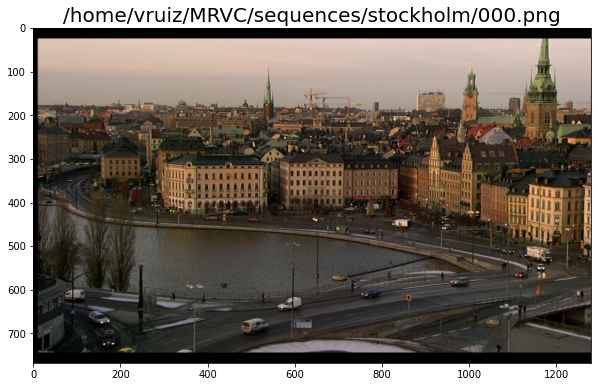

In [5]:
# Read the image and show it.

img = frame.read(fn)
print(img.max(), img.min())

def show(img, title):
    img = frame.normalize(img)
    plt.figure(figsize=(10,10))
    plt.title(title, fontsize=20)
    plt.imshow(img)

show(img, fn + "000.png")

In [6]:
# Some helper functions.

# Number of bytes that a frame "img" requires in disk.
def bytes_per_frame(img):
    frame.write(img, "/tmp/frame")
    length_in_bytes = os.path.getsize("/tmp/frame000.png")
    return length_in_bytes

# The same value, but in bits/pixel.
def bits_per_pixel(img):
    return 8*bytes_per_frame(img)/np.size(img)

# Specific version for grayscale images.
def bytes_per_grayframe(img):
    cv2.imwrite("/tmp/frame000.png", img)
    length_in_bytes = os.path.getsize("/tmp/frame000.png")
    return length_in_bytes

# The same value, but in bits/pixel.
def bits_per_graypixel(img):
    return 8*bytes_per_grayframe(img)/np.size(img)

# Entropy of a sequence of symbols (pixels). This is a theoretical measure
# of the compression ratio of the sequence.
def entropy_in_bits_per_symbol(sequence_of_symbols):
    value, counts = np.unique(sequence_of_symbols, return_counts = True)
    probs = counts / len(sequence_of_symbols)
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    entropy = 0.
    for i in probs:
        entropy -= i * math.log(i, 2)

    return entropy

In [90]:
def R_RD_curve(RGB_frame):
    RD_points = []
    for q in range(Q_steps-1, 0, -1):
        R_frame = RGB_frame[:,:,0]
        q_step = 1 << q
        k, dequantized_R_frame = q_deq(R_frame, q_step)
        k = k.astype(np.uint8)
        rate = bits_per_graypixel(k)
        _distortion = distortion.MSE(R_frame, dequantized_R_frame)
        RD_points.append((rate, _distortion, 'R', q_step))
        print(f"q_step={q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

def G_RD_curve(RGB_frame):
    RD_points = []
    for q in range(Q_steps-1, 0, -1):
        G_frame = RGB_frame[:,:,1]
        q_step = 1 << q
        k, dequantized_G_frame = q_deq(G_frame, q_step)
        k = k.astype(np.uint8)
        rate = bits_per_graypixel(k)
        _distortion = distortion.MSE(G_frame, dequantized_G_frame)
        RD_points.append((rate, _distortion, 'G', q_step))
        print(f"q_step={q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

def B_RD_curve(RGB_frame):
    RD_points = []
    for q in range(Q_steps-1, 0, -1):
        B_frame = RGB_frame[:,:,2]
        q_step = 1 << q
        k, dequantized_B_frame = q_deq(B_frame, q_step)
        k = k.astype(np.uint8)
        rate = bits_per_graypixel(k)
        _distortion = distortion.MSE(B_frame, dequantized_B_frame)
        RD_points.append((rate, _distortion, 'B', q_step))
        print(f"q_step={q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

R_points = R_RD_curve(img)
G_points = G_RD_curve(img)
B_points = B_RD_curve(img)

q_step=128, rate=0.2367919921875 bytes, distortion=4070.7
q_step= 64, rate=0.687451171875 bytes, distortion=1237.6
q_step= 32, rate=1.1222493489583334 bytes, distortion= 297.9
q_step= 16, rate=1.7023844401041666 bytes, distortion=  71.6
q_step=  8, rate=2.359358723958333 bytes, distortion=  16.2
q_step=  4, rate=3.1396158854166667 bytes, distortion=   3.3
q_step=  2, rate=4.027913411458333 bytes, distortion=   0.5
q_step=128, rate=0.17417805989583332 bytes, distortion=3347.1
q_step= 64, rate=0.6687662760416667 bytes, distortion=1269.2
q_step= 32, rate=1.0922688802083333 bytes, distortion= 282.5
q_step= 16, rate=1.6623779296875 bytes, distortion=  71.5
q_step=  8, rate=2.3152587890625 bytes, distortion=  16.0
q_step=  4, rate=3.0933024088541665 bytes, distortion=   3.3
q_step=  2, rate=3.977978515625 bytes, distortion=   0.5
q_step=128, rate=0.11015625 bytes, distortion=2459.6
q_step= 64, rate=0.579150390625 bytes, distortion=1211.9
q_step= 32, rate=1.0861897786458334 bytes, distortion=

In [91]:
R_points

[(0.2367919921875, 4070.7462829589845, 'R', 128),
 (0.687451171875, 1237.6181579589843, 'R', 64),
 (1.1222493489583334, 297.8675069173177, 'R', 32),
 (1.7023844401041666, 71.64826863606771, 'R', 16),
 (2.359358723958333, 16.196348063151042, 'R', 8),
 (3.1396158854166667, 3.253013102213542, 'R', 4),
 (4.027913411458333, 0.46298624674479166, 'R', 2)]

In [92]:
G_points

[(0.17417805989583332, 3347.089042154948, 'G', 128),
 (0.6687662760416667, 1269.164042154948, 'G', 64),
 (1.0922688802083333, 282.5067504882812, 'G', 32),
 (1.6623779296875, 71.48643798828125, 'G', 16),
 (2.3152587890625, 16.038260904947915, 'G', 8),
 (3.0933024088541665, 3.2574422200520834, 'G', 4),
 (3.977978515625, 0.46448974609375, 'G', 2)]

In [93]:
B_points

[(0.11015625, 2459.6197052001953, 'B', 128),
 (0.579150390625, 1211.8919708251954, 'B', 64),
 (1.0861897786458334, 289.5169708251953, 'B', 32),
 (1.6618570963541666, 69.94815572102864, 'B', 16),
 (2.3227945963541665, 15.874620564778645, 'B', 8),
 (3.1035563151041665, 3.1895538330078126, 'B', 4),
 (3.9906005859375, 0.4571482340494792, 'B', 2)]

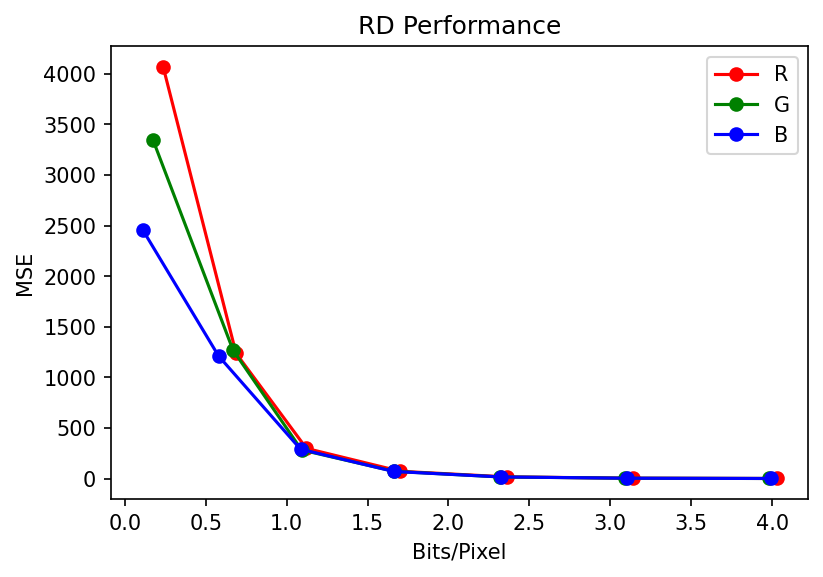

In [94]:
pylab.figure(dpi=150)
pylab.plot(*zip(*[(i[0], i[1]) for i in R_points]), c='r', marker="o",
           label='R')              
pylab.plot(*zip(*[(i[0], i[1]) for i in G_points]), c='g', marker="o",
           label='G')              
pylab.plot(*zip(*[(i[0], i[1]) for i in B_points]), c='b', marker="o",
           label='B')              
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

## Compute the slopes
A list for each component.

In [102]:
components = ['R', 'G', 'B']
def compute_slopes(RD_points):
    extended_RD_points = [(0.0, 0.0, '', -1)] + RD_points
    counter = 0
    RD_slopes = []
    for i in RD_points:
        BPP = i[0] # Rate 
        #print(RD_points[counter])
        delta_BPP = BPP - extended_RD_points[counter][0]
        MSE = i[1] # Distortion
        delta_MSE = MSE - extended_RD_points[counter][1] 
        #print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
        if delta_BPP > 0:
            slope = abs(delta_MSE/delta_BPP)
        else:
            slope = 0
        component = i[2]
        q_step = i[3]
        print((slope, i), delta_MSE, delta_BPP)
        RD_slopes.append((slope, i))
        counter += 1
    RD_slopes.append((0.0, (0.0, RD_points[-1][2], 1)))
    return RD_slopes

R_slopes = compute_slopes(R_points)
G_slopes = compute_slopes(G_points)
B_slopes = compute_slopes(B_points)

(17191.232884833487, (0.2367919921875, 4070.7462829589845, 'R', 128)) 4070.7462829589845 0.2367919921875
(6286.631345143291, (0.687451171875, 1237.6181579589843, 'R', 64)) -2833.128125 0.4506591796875
(2161.3491053380244, (1.1222493489583334, 297.8675069173177, 'R', 32)) -939.7506510416665 0.43479817708333335
(389.94234572923546, (1.7023844401041666, 71.64826863606771, 'R', 16)) -226.21923828125 0.5801350911458332
(84.40500935227739, (2.359358723958333, 16.196348063151042, 'R', 8)) -55.45192057291667 0.6569742838541666
(16.58855003233275, (3.1396158854166667, 3.253013102213542, 'R', 4)) -12.9433349609375 0.7802571614583336
(3.1408697803103887, (4.027913411458333, 0.46298624674479166, 'R', 2)) -2.79002685546875 0.8882975260416663
(19216.479068354904, (0.17417805989583332, 3347.089042154948, 'G', 128)) 3347.089042154948 0.17417805989583332
(4201.323307280954, (0.6687662760416667, 1269.164042154948, 'G', 64)) -2077.925 0.49458821614583337
(2329.7549577248274, (1.0922688802083333, 282.5067

In [103]:
R_slopes

[(17191.232884833487, (0.2367919921875, 4070.7462829589845, 'R', 128)),
 (6286.631345143291, (0.687451171875, 1237.6181579589843, 'R', 64)),
 (2161.3491053380244, (1.1222493489583334, 297.8675069173177, 'R', 32)),
 (389.94234572923546, (1.7023844401041666, 71.64826863606771, 'R', 16)),
 (84.40500935227739, (2.359358723958333, 16.196348063151042, 'R', 8)),
 (16.58855003233275, (3.1396158854166667, 3.253013102213542, 'R', 4)),
 (3.1408697803103887, (4.027913411458333, 0.46298624674479166, 'R', 2)),
 (0.0, (0.0, 'R', 1))]

In [104]:
G_slopes

[(19216.479068354904, (0.17417805989583332, 3347.089042154948, 'G', 128)),
 (4201.323307280954, (0.6687662760416667, 1269.164042154948, 'G', 64)),
 (2329.7549577248274, (1.0922688802083333, 282.5067504882812, 'G', 32)),
 (370.14026122332444, (1.6623779296875, 71.48643798828125, 'G', 16)),
 (84.92847705232721, (2.3152587890625, 16.038260904947915, 'G', 8)),
 (16.426866514653888, (3.0933024088541665, 3.2574422200520834, 'G', 4)),
 (3.1570339162350867, (3.977978515625, 0.46448974609375, 'G', 2)),
 (0.0, (0.0, 'G', 1))]

In [105]:
B_slopes

[(22328.46257203014, (0.11015625, 2459.6197052001953, 'B', 128)),
 (2660.433524206143, (0.579150390625, 1211.8919708251954, 'B', 64)),
 (1819.1387529090757, (1.0861897786458334, 289.5169708251953, 'B', 32)),
 (381.4161553903137, (1.6618570963541666, 69.94815572102864, 'B', 16)),
 (81.81338652482269, (2.3227945963541665, 15.874620564778645, 'B', 8)),
 (16.24703981655201, (3.1035563151041665, 3.1895538330078126, 'B', 4)),
 (3.0803486238532107, (3.9906005859375, 0.4571482340494792, 'B', 2)),
 (0.0, (0.0, 'B', 1))]

## Merge the RD slopes and sort them

In [113]:
RD_slopes = R_slopes + G_slopes + B_slopes
optimal_slopes = sorted(RD_slopes, key=lambda x: x[0])[::-1]

In [114]:
optimal_slopes

[(22328.46257203014, (0.11015625, 2459.6197052001953, 'B', 128)),
 (19216.479068354904, (0.17417805989583332, 3347.089042154948, 'G', 128)),
 (17191.232884833487, (0.2367919921875, 4070.7462829589845, 'R', 128)),
 (6286.631345143291, (0.687451171875, 1237.6181579589843, 'R', 64)),
 (4201.323307280954, (0.6687662760416667, 1269.164042154948, 'G', 64)),
 (2660.433524206143, (0.579150390625, 1211.8919708251954, 'B', 64)),
 (2329.7549577248274, (1.0922688802083333, 282.5067504882812, 'G', 32)),
 (2161.3491053380244, (1.1222493489583334, 297.8675069173177, 'R', 32)),
 (1819.1387529090757, (1.0861897786458334, 289.5169708251953, 'B', 32)),
 (389.94234572923546, (1.7023844401041666, 71.64826863606771, 'R', 16)),
 (381.4161553903137, (1.6618570963541666, 69.94815572102864, 'B', 16)),
 (370.14026122332444, (1.6623779296875, 71.48643798828125, 'G', 16)),
 (84.92847705232721, (2.3152587890625, 16.038260904947915, 'G', 8)),
 (84.40500935227739, (2.359358723958333, 16.196348063151042, 'R', 8)),
 (8

## Accumulate bit-rates

In [121]:
def accumulate_rate(points_sorted_by_slopes):
    optimal_points = []
    accumulated_BR = 0.0
    for i in points_sorted_by_slopes:
        BPP = i[1][0]; MSE = i[1][1]
        accumulated_BR += BPP
        optimal_points.append((accumulated_BR, MSE))
    return optimal_points

optimal_points = accumulate_rate(optimal_slopes)

In [122]:
optimal_points

[(0.11015625, 2459.6197052001953),
 (0.2843343098958333, 3347.089042154948),
 (0.5211263020833333, 4070.7462829589845),
 (1.2085774739583335, 1237.6181579589843),
 (1.87734375, 1269.164042154948),
 (2.456494140625, 1211.8919708251954),
 (3.5487630208333334, 282.5067504882812),
 (4.671012369791667, 297.8675069173177),
 (5.7572021484375, 289.5169708251953),
 (7.459586588541667, 71.64826863606771),
 (9.121443684895834, 69.94815572102864),
 (10.783821614583333, 71.48643798828125),
 (13.099080403645832, 16.038260904947915),
 (15.458439127604166, 16.196348063151042),
 (17.781233723958334, 15.874620564778645),
 (20.920849609375, 3.253013102213542),
 (24.01415201822917, 3.2574422200520834),
 (27.117708333333336, 3.1895538330078126),
 (31.095686848958337, 0.46448974609375),
 (35.12360026041667, 0.46298624674479166),
 (39.11420084635417, 0.4571482340494792),
 (39.11420084635417, 'B'),
 (39.11420084635417, 'G'),
 (39.11420084635417, 'R')]

## RD curve using same $\Delta$ for each RGB channel ($\Delta_{\text{R}} = \Delta_{\text{G}} = \Delta_{\text{B}}$)
To see the contribution of each channel to the RD curve.

In [87]:
def constant_Q_RD_curve(x):
    points = []
    for q_step in range(0, 8):
        k, y = q_deq(x, 1<<q_step)
        k = k.astype(np.uint8)
        rate = bits_per_pixel(k)
        _distortion = distortion.MSE(x, y)
        points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return points

constant_Q_RD_points = constant_Q_RD_curve(img)

image_3.write: /tmp/frame000.png (768, 1280, 3) uint8 1781413 
q_step=  1, rate=4.832392035590278 bytes, distortion=   0.0
image_3.write: /tmp/frame000.png (768, 1280, 3) uint8 1447223 
q_step=  2, rate=3.9258436414930555 bytes, distortion=   0.5
image_3.write: /tmp/frame000.png (768, 1280, 3) uint8 1121458 
q_step=  4, rate=3.0421495225694444 bytes, distortion=   3.2
image_3.write: /tmp/frame000.png (768, 1280, 3) uint8 829269 
q_step=  8, rate=2.2495361328125 bytes, distortion=  16.0
image_3.write: /tmp/frame000.png (768, 1280, 3) uint8 604930 
q_step= 16, rate=1.6409776475694444 bytes, distortion=  71.0
image_3.write: /tmp/frame000.png (768, 1280, 3) uint8 409803 
q_step= 32, rate=1.1116617838541667 bytes, distortion= 290.0
image_3.write: /tmp/frame000.png (768, 1280, 3) uint8 238379 
q_step= 64, rate=0.6466444227430556 bytes, distortion=1239.6
image_3.write: /tmp/frame000.png (768, 1280, 3) uint8 60200 
q_step=128, rate=0.1633029513888889 bytes, distortion=3292.5


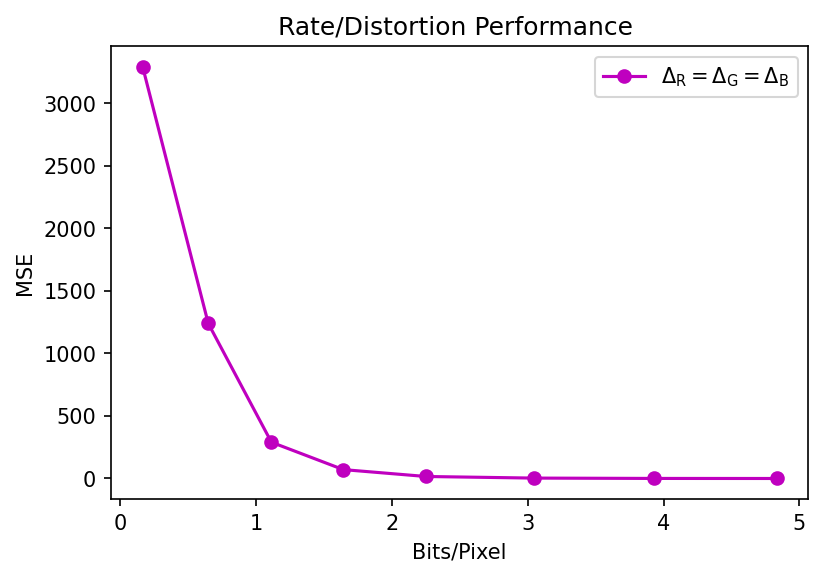

In [120]:
pylab.figure(dpi=150)
pylab.plot(*zip(*constant_Q_RD_points), c='m', marker="o", label="$\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}}$")
#pylab.plot(*zip(*optimal_RD_points), c='m', marker="o", label="$\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}}$")
pylab.title("Rate/Distortion Performance ")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
pylab.legend(loc='upper right')
pylab.show()

## Compute slopes

In [44]:
def compute_slopes(RD_points):
    extended_RD_points = [(0.0, 9.0E9, '', -1)] + RD_points
    counter = 0
    RD_slopes = []
    for i in RD_points:
        BPP = i[0] # Rate 
        print(RD_points[counter])
        delta_BPP = BPP - extended_RD_points[counter][0]
        MSE = i[1] # Distortion
        delta_MSE = MSE - extended_RD_points[counter][1] 
        #print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
        if delta_BPP > 0:
            slope = delta_MSE/delta_BPP
        else:
            slope = 0
        RD_slopes.append((slope, i[2], i[3]))
        counter += 1
    return RD_slopes

RD_slopes = compute_slopes(sorted_RD_points)

(0.11015625, 2459.6197052001953, 'B', 7)
(0.17417805989583332, 3347.089042154948, 'G', 7)
(0.2367919921875, 4070.7462829589845, 'R', 7)
(0.579150390625, 1211.8919708251954, 'B', 6)
(0.6687662760416667, 1269.164042154948, 'G', 6)
(0.687451171875, 1237.6181579589843, 'R', 6)
(1.0861897786458334, 289.5169708251953, 'B', 5)
(1.0922688802083333, 282.5067504882812, 'G', 5)
(1.1222493489583334, 297.8675069173177, 'R', 5)
(1.6618570963541666, 69.94815572102864, 'B', 4)
(1.6623779296875, 71.48643798828125, 'G', 4)
(1.7023844401041666, 71.64826863606771, 'R', 4)
(2.3152587890625, 16.038260904947915, 'G', 3)
(2.3227945963541665, 15.874620564778645, 'B', 3)
(2.359358723958333, 16.196348063151042, 'R', 3)
(3.0933024088541665, 3.2574422200520834, 'G', 2)
(3.1035563151041665, 3.1895538330078126, 'B', 2)
(3.1396158854166667, 3.253013102213542, 'R', 2)
(3.977978515625, 0.46448974609375, 'G', 1)
(3.9906005859375, 0.4571482340494792, 'B', 1)
(4.027913411458333, 0.46298624674479166, 'R', 1)
(4.91000976562

In [45]:
RD_slopes

[(-81702105331.1119, 'B', 7),
 (13861.984508071695, 'G', 7),
 (11557.447589030413, 'R', 7),
 (-8350.472268772732, 'B', 6),
 (639.0839198147472, 'G', 6),
 (-1688.3093423345044, 'R', 6),
 (-2377.7511658877065, 'B', 5),
 (-1153.1671686747175, 'G', 5),
 (512.3587812160696, 'R', 5),
 (-422.3796865338503, 'B', 4),
 (2953.501953123923, 'G', 4),
 (4.045107811228684, 'R', 4),
 (-90.73639290930821, 'G', 3),
 (-21.715037796976, 'B', 3),
 (8.798992877809967, 'R', 3),
 (-17.629289698071783, 'G', 2),
 (-6.620734126984124, 'B', 2),
 (1.7598454073572478, 'R', 2),
 (-3.326154167232912, 'G', 1),
 (-0.5816408768536323, 'B', 1),
 (0.1564612868047989, 'R', 1),
 (-0.5248703778876666, 'G', 0),
 (0.0, 'B', 0),
 (0.0, 'R', 0)]

In [ ]:
print(RD_points)

In [ ]:
with open('RGB.txt', 'w') as f:
    for item in RD_points:
        f.write(f"{item[0]}\t{item[1]}\n")

In [ ]:
k, y = q_deq(img, 64)
show(y, "")

## RD curves of each channel

In [ ]:
def only_R_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        R_frame = RGB_frame[:,:,0]
        k, dequantized_R_frame = q_deq(R_frame, 1<<q_step)
        k = k.astype(np.uint8)
        rate = bits_per_graypixel(k)
        _distortion = distortion.MSE(R_frame, dequantized_R_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

def only_G_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        G_frame = RGB_frame[:,:,1]
        k, dequantized_G_frame = q_deq(G_frame, 1<<q_step)
        k = k.astype(np.uint8)
        rate = bits_per_graypixel(k)
        _distortion = distortion.MSE(G_frame, dequantized_G_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

def only_B_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        B_frame = RGB_frame[:,:,2]
        k, dequantized_B_frame = q_deq(B_frame, 1<<q_step)
        k = k.astype(np.uint8)
        rate = bits_per_graypixel(k)
        _distortion = distortion.MSE(B_frame, dequantized_B_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

only_R_points = only_R_RD_curve(img)
only_G_points = only_G_RD_curve(img)
only_B_points = only_B_RD_curve(img)

In [ ]:
only_B_points

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points), c='m', marker="x",
           label='$\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$')
pylab.plot(*zip(*only_R_points), c='r', marker="o",
           label='Only R')              
pylab.plot(*zip(*only_G_points), c='g', marker="o",
           label='Only G')              
pylab.plot(*zip(*only_B_points), c='b', marker="o",
           label='Only B')              
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

The $\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$ quantization scheme is near optimal because the slope at the different quantization points is almost the same. This can be seen in the next experiment

## Testing a different quantization configuration

In [ ]:
N = 6
def only_R_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        dequantized_RGB_frame = np.empty_like(RGB_frame)
        k = np.empty_like(RGB_frame)
        k[:,:,0], dequantized_RGB_frame[:,:,0] = q_deq(RGB_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_RGB_frame[:,:,1] = q_deq(RGB_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_RGB_frame[:,:,2] = q_deq(RGB_frame[:,:,2], 1<<N)
        k = k.astype(np.uint8)
        rate = bits_per_pixel(k)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

def only_G_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        dequantized_RGB_frame = np.empty_like(RGB_frame)
        k = np.empty_like(RGB_frame)
        k[:,:,0], dequantized_RGB_frame[:,:,0] = q_deq(RGB_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_RGB_frame[:,:,1] = q_deq(RGB_frame[:,:,1], 1<<q_step)
        k[:,:,2], dequantized_RGB_frame[:,:,2] = q_deq(RGB_frame[:,:,2], 1<<N)
        k = k.astype(np.uint8)
        rate = bits_per_pixel(k)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

def only_B_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        dequantized_RGB_frame = np.empty_like(RGB_frame)
        k = np.empty_like(RGB_frame)
        k[:,:,0], dequantized_RGB_frame[:,:,0] = q_deq(RGB_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_RGB_frame[:,:,1] = q_deq(RGB_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_RGB_frame[:,:,2] = q_deq(RGB_frame[:,:,2], 1<<q_step)
        k = k.astype(np.uint8)
        rate = bits_per_pixel(k)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

only_R_points = only_R_RD_curve(img)
only_G_points = only_G_RD_curve(img)
only_B_points = only_B_RD_curve(img)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points), c='m', marker="x",
           label='$\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$')
pylab.plot(*zip(*only_R_points), c='r', marker="o",
           label='$\Delta_{\mathrm{R}}~\mathrm{varies},~\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_G_points), c='g', marker="o",
           label='$\Delta_{\mathrm{G}}~\mathrm{varies},~\Delta_{\mathrm{R}}=\Delta_{\mathrm{B}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_B_points), c='b', marker="o",
           label='$\Delta_{\mathrm{B}}~\mathrm{varies},~\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=$' + '{}'.format(1<<N))              
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

As it can be seen, the best configuration matches $\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$.

Lo que hay que hacer es calcular el slope para cada OTP (Optimal Truncated Point) de cada canal, ordenarlos y trazar la curva RD. Esto nos daría la curva RD óptima.